In [1]:
!pip install hazm
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 371.7/371.7 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 16.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 35.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 52.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.7/227.7 kB 19.3 MB/s eta 0:00:00
  Created wheel for flashtext: filename=flashtext-2.7-py2.py3-none-any.whl size=9296 sha256=30297dc81c6a69c12a9f174a30b1de49da6f31d4137b717211c6d33ccae3ee42
  Stored in directory: /root/.cache/pip/wheels/bc/be/39/c37ad168eb2ff644c9685f52554440372129450f0b8ed203dd
Successfully built flashtext
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This

In [1]:

import numpy as np
import pandas as pd

import hazm
import re

import os
import collections

import plotly.express as px
import plotly.graph_objects as go

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.utils import shuffle

from transformers import BertConfig, BertTokenizer
from transformers import BertModel

from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup

from tqdm.notebook import tqdm

In [2]:
df = pd.read_csv("/content/Snappfood - Sentiment Analysis.csv", on_bad_lines='skip', delimiter='\t')

In [3]:
df.head()

,Unnamed: 0,comment,label,label_id
0,NaN,واقعا حیف وقت که بنویسم سرویس دهیتون شده افتضاح,SAD,1.0
1,NaN,قرار بود ۱ ساعته برسه ولی نیم ساعت زودتر از مو...,HAPPY,0.0
2,NaN,قیمت این مدل اصلا با کیفیتش سازگاری نداره، فقط...,SAD,1.0
3,NaN,عالللی بود همه چه درست و به اندازه و کیفیت خوب...,HAPPY,0.0
4,NaN,شیرینی وانیلی فقط یک مدل بود.,HAPPY,0.0


In [4]:
df = df.drop(columns=['Unnamed: 0'])

In [5]:
df.head()

,comment,label,label_id
0,واقعا حیف وقت که بنویسم سرویس دهیتون شده افتضاح,SAD,1.0
1,قرار بود ۱ ساعته برسه ولی نیم ساعت زودتر از مو...,HAPPY,0.0
2,قیمت این مدل اصلا با کیفیتش سازگاری نداره، فقط...,SAD,1.0
3,عالللی بود همه چه درست و به اندازه و کیفیت خوب...,HAPPY,0.0
4,شیرینی وانیلی فقط یک مدل بود.,HAPPY,0.0


In [6]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   comment   70000 non-null  object 
 1   label     70000 non-null  object 
 2   label_id  69480 non-null  float64
dtypes: float64(1), object(2)
memory usage: 1.6+ MB


In [7]:
df.dropna(inplace=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69480 entries, 0 to 69999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   comment   69480 non-null  object 
 1   label     69480 non-null  object 
 2   label_id  69480 non-null  float64
dtypes: float64(1), object(2)
memory usage: 2.1+ MB


In [9]:
df = df.drop_duplicates(subset=['comment'], keep="first")

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69480 entries, 0 to 69999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   comment   69480 non-null  object 
 1   label     69480 non-null  object 
 2   label_id  69480 non-null  float64
dtypes: float64(1), object(2)
memory usage: 2.1+ MB


In [11]:
df = df.reset_index(drop=True)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69480 entries, 0 to 69479
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   comment   69480 non-null  object 
 1   label     69480 non-null  object 
 2   label_id  69480 non-null  float64
dtypes: float64(1), object(2)
memory usage: 1.6+ MB


In [13]:
df['label_id'] = df['label_id'].astype(int)


In [14]:
labels = ["HAPPY", "SAD"]

In [15]:
df.head()

,comment,label,label_id
0,واقعا حیف وقت که بنویسم سرویس دهیتون شده افتضاح,SAD,1
1,قرار بود ۱ ساعته برسه ولی نیم ساعت زودتر از مو...,HAPPY,0
2,قیمت این مدل اصلا با کیفیتش سازگاری نداره، فقط...,SAD,1
3,عالللی بود همه چه درست و به اندازه و کیفیت خوب...,HAPPY,0
4,شیرینی وانیلی فقط یک مدل بود.,HAPPY,0


In [16]:
df['comment_len_by_word'] = df['comment'].apply(lambda t: len(hazm.word_tokenize(t)))

In [17]:
hazm.word_tokenize(df['comment'][0])

['واقعا', 'حیف', 'وقت', 'که', 'بنویسم', 'سرویس', 'دهیتون', 'شده', 'افتضاح']

In [18]:
df.head()

,comment,label,label_id,comment_len_by_word
0,واقعا حیف وقت که بنویسم سرویس دهیتون شده افتضاح,SAD,1,9
1,قرار بود ۱ ساعته برسه ولی نیم ساعت زودتر از مو...,HAPPY,0,28
2,قیمت این مدل اصلا با کیفیتش سازگاری نداره، فقط...,SAD,1,19
3,عالللی بود همه چه درست و به اندازه و کیفیت خوب...,HAPPY,0,21
4,شیرینی وانیلی فقط یک مدل بود.,HAPPY,0,7


In [19]:
min_max_len = df['comment_len_by_word'].min(), df['comment_len_by_word'].max()

In [20]:
print(f'minimum is {min_max_len[0]} and the maximum is {min_max_len[1]}')

minimum is 2 and the maximum is 378


In [21]:
data_length = df['comment_len_by_word'].values
data_length

array([ 9, 28, 19, ..., 56, 11,  5])

In [22]:
data_length[0]

9

In [23]:
sum([1 for length in data_length if 3 < length <= 150])

69279

In [24]:
count = 0
for i in range (len(data_length)):
  if 3 < data_length[i] <= 150:
    count +=1
rate = (count / len(data_length))*100
rate

99.71070811744387

In [25]:
def data_gl_than(data, min_len=3, max_len=150, columns='comment_len_by_word'):
  data_length = df['comment_len_by_word'].values
  count = 0
  for i in range (len(data_length)):
    if 3 < data_length[i] <= 150:
      count +=1
  rate = (count / len(data_length))*100
  return min_len , max_len, rate

In [26]:
data_gl = data_gl_than(df)
print(f'Texts with word length of greater than {data_gl[0]} and less than {data_gl[1]} includes {data_gl[2]:.2f}% of the whole!')

Texts with word length of greater than 3 and less than 150 includes 99.71% of the whole!


In [27]:
min_lim , max_lim, rate = data_gl

In [28]:
df['comment_len_by_word'] = df['comment_len_by_word'].apply(lambda len_t: len_t if min_lim< len_t <=max_lim else None)

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69480 entries, 0 to 69479
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   comment              69480 non-null  object 
 1   label                69480 non-null  object 
 2   label_id             69480 non-null  int64  
 3   comment_len_by_word  69279 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 2.1+ MB


In [30]:
df = df.dropna(subset=['comment_len_by_word'])
df = df.reset_index(drop=True)

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69279 entries, 0 to 69278
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   comment              69279 non-null  object 
 1   label                69279 non-null  object 
 2   label_id             69279 non-null  int64  
 3   comment_len_by_word  69279 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 2.1+ MB


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69279 entries, 0 to 69278
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   comment              69279 non-null  object 
 1   label                69279 non-null  object 
 2   label_id             69279 non-null  int64  
 3   comment_len_by_word  69279 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 2.1+ MB


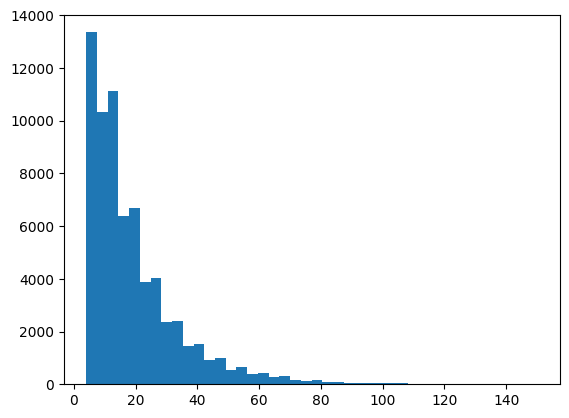

In [33]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
num_bins = 42

# the histogram of the data
n, bins, patches = ax.hist(df['comment_len_by_word'], num_bins)

In [34]:
fig = go.Figure()

fig.add_trace(go.Histogram(
    x=df['comment_len_by_word']
))

In [35]:
df['comment'] = df['comment'].apply(lambda x: re.sub(r'[\da-zA-Z\!\(\)\-\[\]\{\}\;\:\'\"\\\,\<\>\.\/\?\@\#\$\%\^\&\*\_\~\؟\،\٪\×\÷\»\«]', '', x))

In [36]:
df.tail()

,comment,label,label_id,comment_len_by_word
69274,سلام من به فاکتور غذاهایی که سفارش میدم احتیاج...,SAD,1,49.0
69275,سایز پیتزا نسبت به سفارشاتی که قبلا گذشتم کم ش...,SAD,1,10.0
69276,من قارچ اضافه رو اضافه کرده بودم بودم اما اگر ...,HAPPY,0,56.0
69277,همرو بعد ساعت تاخیر اشتباه آوردن پولشم رفت رو هوا,SAD,1,11.0
69278,فلفلش خییییلی تند بود,HAPPY,0,5.0


In [37]:
normalizer = hazm.Normalizer()

In [38]:
df['comment'] = df['comment'].apply(lambda x: normalizer.normalize(x.strip()))

In [39]:
df.tail()

,comment,label,label_id,comment_len_by_word
69274,سلام من به فاکتور غذاهایی که سفارش میدم احتیاج...,SAD,1,49.0
69275,سایز پیتزا نسبت به سفارشاتی که قبلا گذشتم کم ش...,SAD,1,10.0
69276,من قارچ اضافه رو اضافه کرده بودم بودم اما اگر ...,HAPPY,0,56.0
69277,همرو بعد ساعت تاخیر اشتباه آوردن پولشم رفت رو هوا,SAD,1,11.0
69278,فلفلش خیلی تند بود,HAPPY,0,5.0


In [40]:
df['comment_len_by_word_clean'] = df['comment'].apply(lambda x: len(hazm.word_tokenize(x)))
df['comment_len_by_word_clean'] = df['comment_len_by_word_clean'].apply(lambda len_x: len_x if min_lim < len_x <= max_lim else None)

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69279 entries, 0 to 69278
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   comment                    69279 non-null  object 
 1   label                      69279 non-null  object 
 2   label_id                   69279 non-null  int64  
 3   comment_len_by_word        69279 non-null  float64
 4   comment_len_by_word_clean  68740 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 2.6+ MB


In [42]:
df = df.dropna(subset=['comment_len_by_word_clean'])
df = df.reset_index(drop=True)

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68740 entries, 0 to 68739
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   comment                    68740 non-null  object 
 1   label                      68740 non-null  object 
 2   label_id                   68740 non-null  int64  
 3   comment_len_by_word        68740 non-null  float64
 4   comment_len_by_word_clean  68740 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 2.6+ MB


In [44]:
df.head()

,comment,label,label_id,comment_len_by_word,comment_len_by_word_clean
0,واقعا حیف وقت که بنویسم سرویس دهیتون شده افتضاح,SAD,1,9.0,9.0
1,قرار بود ساعته برسه ولی نیم ساعت زودتر از موقع...,HAPPY,0,28.0,25.0
2,قیمت این مدل اصلا با کیفیتش سازگاری نداره فقط ...,SAD,1,19.0,17.0
3,عالی بود همه چه درست و به اندازه و کیفیت خوب ا...,HAPPY,0,21.0,20.0
4,شیرینی وانیلی فقط یک مدل بود,HAPPY,0,7.0,6.0


In [45]:
train, test_valid = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label_id'])
test, valid = train_test_split(test_valid, test_size=0.5, random_state=42, stratify=test_valid['label_id'])



In [46]:
x_train, y_train = train['comment'].values.tolist(), train['label_id'].values.tolist()
x_valid, y_valid = valid['comment'].values.tolist(), valid['label_id'].values.tolist()
x_test, y_test = test['comment'].values.tolist(), test['label_id'].values.tolist()

In [47]:
print(train.shape)
print(valid.shape)
print(test.shape)

(54992, 5)
(6874, 5)
(6874, 5)


In [48]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'device: {device}')
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.')
else:
    print('CUDA is available!')

device: cuda:0
CUDA is available!


In [49]:
max_len = 128
train_batch_size = 16
valid_batch_size = 16
test_batch_size = 16

epochs = 3
every_epoch = 1000
lr = 2e-5
clip = 0.0

MODEL_PATH = 'HooshvareLab/bert-fa-base-uncased'
OUTPUT_PATH = '/content/bert-fa-base-uncased-sentiment-taaghceh/pytorch_model.bin'
os.makedirs(os.path.dirname(OUTPUT_PATH), exist_ok=True)

In [50]:
label2id = {value: key for key, value in enumerate(labels)}
id2label = {key: value for key, value in enumerate(labels)}

In [51]:
print(label2id)
print(id2label)

{'HAPPY': 0, 'SAD': 1}
{0: 'HAPPY', 1: 'SAD'}


In [52]:
tokenizer = BertTokenizer.from_pretrained(MODEL_PATH)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



vocab.txt:   0%|          | 0.00/1.20M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/440 [00:00<?, ?B/s]

In [53]:
config = BertConfig.from_pretrained(MODEL_PATH, **{
    'label2id':label2id,
    'id2label':id2label
})
print(config.to_json_string())

{
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "HAPPY",
    "1": "SAD"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "HAPPY": 0,
    "SAD": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.35.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 100000
}



In [54]:
idx = np.random.randint(0, len(train))
idx

45410

In [55]:
sample_comment = train.iloc[idx]['comment']

In [56]:
sample_comment

'متاسفانه شیرینی تازه نبود و سفت شده بود'

In [57]:
tokens = tokenizer.tokenize(sample_comment)
tokens_id = tokenizer.convert_tokens_to_ids(tokens)

In [58]:
print(tokens)
print(tokens_id)

['متاسفانه', 'شیرینی', 'تازه', 'نبود', 'و', 'سفت', 'شده', 'بود']
[5571, 9278, 4923, 3827, 1379, 12777, 2871, 2834]


In [59]:
encoding = tokenizer.encode_plus(
    sample_comment,
    max_length=32,
    truncation=True,
    add_special_tokens=True,
    return_token_type_ids=True,
    return_attention_mask=True,
    padding='max_length',
    return_tensors='pt'
)

In [60]:
print(f'Keys: {encoding.keys()}\n')

Keys: dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])



In [61]:
for keys in encoding.keys():
  print(keys, ": ",encoding[keys])

input_ids :  tensor([[    2,  5571,  9278,  4923,  3827,  1379, 12777,  2871,  2834,     4,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0]])
token_type_ids :  tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])
attention_mask :  tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])


In [62]:
class SnapFoodDataset(torch.utils.data.Dataset):
  def __init__(self, tokenizer, comments, targets=None, max_len=128):
    self.tokenizer = tokenizer
    self.comments = comments
    self.targets = targets
    self.max_len = max_len

  def __len__(self):
    return len(self.comments)

  def __getitem__(self, item):
    comment = str(self.comments[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
      comment,
      max_length=self.max_len,
      truncation=True,
      add_special_tokens=True,
      return_token_type_ids=True,
      return_attention_mask=True,
      padding='max_length',
      return_tensors='pt'
    )
    inputs = {
        'comment': comment,
        'input_ids': encoding['input_ids'].flatten(),
        'attention_mask': encoding['attention_mask'].flatten(),
        'token_type_ids': encoding['token_type_ids'].flatten()
    }
    inputs['targets'] = torch.tensor(target, dtype=torch.long)
    return inputs

In [63]:
train_data_loader = torch.utils.data.DataLoader(
    SnapFoodDataset(tokenizer=tokenizer, comments=train['comment'].to_numpy(), targets=train['label_id'].to_numpy()),
    batch_size=train_batch_size
)
valid_data_loader = torch.utils.data.DataLoader(
    SnapFoodDataset(tokenizer=tokenizer, comments=valid['comment'].to_numpy(), targets=valid['label_id'].to_numpy()),
    batch_size=valid_batch_size
)
test_data_loader = torch.utils.data.DataLoader(
    SnapFoodDataset(tokenizer=tokenizer, comments=test['comment'].to_numpy(), targets=test['label_id'].to_numpy()),
    batch_size=test_batch_size
)

In [64]:
class SentimentModel(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.bert = BertModel.from_pretrained(MODEL_PATH, return_dict=False)
    self.dropout = nn.Dropout(config.hidden_dropout_prob)
    self.classifier = nn.Linear(config.hidden_size, 2)

  def forward(self, input_ids, attention_mask, token_type_ids):
    _, pooled_output = self.bert(
        input_ids=input_ids,
        attention_mask=attention_mask,
        token_type_ids=token_type_ids
    )
    pooled_output = self.dropout(pooled_output)
    logits = self.classifier(pooled_output)
    return logits

In [65]:
model = SentimentModel(config=config)

pytorch_model.bin:   0%|          | 0.00/654M [00:00<?, ?B/s]

In [66]:
pt_model = model.to(device)

In [67]:
optimizer = torch.optim.Adam(pt_model.parameters(), lr=lr)
criteria = nn.CrossEntropyLoss() #---> because of this loss function first use log softmax we pass to it logits(outputs) not predictions
num_training_step = len(train_data_loader)*epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_step)
best_eval_loss = np.Inf
history = collections.defaultdict(list)

In [68]:
best_eval_loss

inf

In [69]:
def yresult(y_true, y_predict):
  '''
  this function return y_true and y_predict as numpy array
  '''

  y_true = torch.stack(y_true).cpu().detach().numpy()
  y_predict = torch.stack(y_predict).cpu().detach().numpy()

  return [y_true, y_predict]

def loss_cal(loss):
  total_loss = np.mean(loss)
  return total_loss

from sklearn.metrics import accuracy_score
def accuracy(y_true, y_predict):
  acc = accuracy_score(y_true, y_predict)
  return acc

def fscore(y_true, y_predict):
  score = f1_score(y_true, y_predict, average='weighted')
  return score

In [70]:
def evaluater(model, valid_dl, criteria):
  model.eval()
  losses = []
  y_pred = []
  y_true = []
  with torch.no_grad():
    for data in tqdm(valid_dl, total=len(valid_dl), desc="Evaluation... "):
      input_ids = data['input_ids'].to(device)
      attention_mask = data['attention_mask'].to(device)
      token_type_ids = data['token_type_ids'].to(device)
      targets = data['targets'].to(device)

      # forward pass
      outputs = model(input_ids=input_ids,
      attention_mask=attention_mask,
      token_type_ids=token_type_ids) #---> outputs has shape = [batch_size, num_class]
      _, preds = torch.max(outputs, dim=1) #---> when we use dim=1 means get max from num_class and then we have 2 values
                                            # first value (-) is the highest value itself and the seccond value is the class prediction of each value in batch
      loss = criteria(outputs, targets)
      losses.append(loss.item())
      y_pred.extend(preds)
      y_true.extend(targets)

  valid_y_result = yresult(y_true, y_pred)
  valid_loss = loss_cal(losses)
  valid_acc = accuracy(valid_y_result[0],valid_y_result[1])
  valid_fscore = fscore(valid_y_result[0],valid_y_result[1])

  return valid_y_result, valid_loss, valid_acc, valid_fscore


In [71]:
def evaluater_callback(epochs, path):
  def eval_cb(epoch, model, step, train_loss, train_acc, valid_loss, valid_acc, best_valid_loss):
    statement = f'Epoch: {epoch}/{epochs}...'
    statement += f'Step: {step}...'
    statement += f'Train Loss: {train_loss:.6f}... Train Acc: {train_acc:.3f}...'
    statement += f'Valid Loss: {valid_loss:.6f}... Valid Acc: {valid_acc:.3f}'

    print(statement)

    if valid_loss <= best_valid_loss:
      print(f'Validation loss decreased ({best_valid_loss:.6f} --> {valid_loss:.6f}). Saving model...')
      torch.save(model.state_dict(), path)
      best_valid_loss = valid_loss

    return best_valid_loss

In [72]:
def trainer(model, train_dl, optimizer, criteria, scheduler=None, val=False, step=0, print_step=100, eval_cb=None, best_valid_loss=None):
  for epoch in tqdm(range(1, epochs + 1), desc="Epochs... "):
    model.train()
    losses = []
    y_pred = []
    y_true = []
    # for data in train_dl:
    for data in tqdm(train_dl, total=len(train_dl), desc="Training... "):
      step += 1
      input_ids = data['input_ids'].to(device)
      attention_mask = data['attention_mask'].to(device)
      token_type_ids = data['token_type_ids'].to(device)
      targets = data['targets'].to(device)

      # forward pass
      outputs = model(input_ids=input_ids,
      attention_mask=attention_mask,
      token_type_ids=token_type_ids) #---> outputs has shape = [batch_size, num_class]
      _, preds = torch.max(outputs, dim=1) #---> when we use dim=1 means get max from num_class and then we have 2 values
                                                # first value (-) is the highest value itself and the seccond value is the class prediction of each value in batch
      loss = criteria(outputs, targets)
      # backward pass and optimize
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      scheduler.step()
      losses.append(loss.item())
      y_pred.extend(preds)
      y_true.extend(targets)
      if val:
        train_y_result = yresult(y_true, y_pred)
        train_loss = loss_cal(losses)
        train_acc = accuracy(train_y_result[0], train_y_result[1])
        train_fscore = fscore(train_y_result[0], train_y_result[1])

        if step % print_step == 0:
          valid_y_result, valid_loss, valid_acc, valid_fscore = evaluater(model, valid_data_loader, criteria)
          # print("vared shod")
          statement = f'Epoch: {epoch}/{epochs}...'
          statement += f'Step: {step}...'
          statement += f'Train Loss: {train_loss:.6f}... Train Acc: {train_acc:.3f}...'
          statement += f'Valid Loss: {valid_loss:.6f}... Valid Acc: {valid_acc:.3f}'

          print(statement)

          if valid_loss <= best_valid_loss:
            print(f'Validation loss decreased ({best_valid_loss:.6f} --> {valid_loss:.6f}). Saving model...')
            torch.save(model.state_dict(), OUTPUT_PATH)
            best_valid_loss = valid_loss

          # if hasattr(eval_cb, '__call__'):

          #   best_eval_loss = eval_cb(epoch, model, step, train_loss, train_acc, valid_loss, valid_acc, best_valid_loss)
          #   print("vared callback shod")

    train_y_result = yresult(y_true, y_pred)
    train_loss = loss_cal(losses)
    train_acc = accuracy(train_y_result[0], train_y_result[1])
    train_fscore = fscore(train_y_result[0], train_y_result[1])
    valid_y_result, valid_loss, valid_acc, valid_fscore = evaluater(model, valid_data_loader, criteria)
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(valid_acc)
    history['val_loss'].append(valid_loss)

In [73]:
trainer(model=pt_model,
        train_dl=train_data_loader,
        optimizer=optimizer,
        criteria=criteria,
        step=0,
        print_step=1000,
        val=True,
        scheduler=scheduler,
        eval_cb=evaluater_callback(epochs, OUTPUT_PATH),
        best_valid_loss=best_eval_loss
        )

Epochs... :   0%|          | 0/3 [00:00<?, ?it/s]

Training... :   0%|          | 0/3437 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/430 [00:00<?, ?it/s]

Epoch: 1/3...Step: 1000...Train Loss: 0.366409... Train Acc: 0.841...Valid Loss: 0.312101... Valid Acc: 0.872
Validation loss decreased (inf --> 0.312101). Saving model...


Evaluation... :   0%|          | 0/430 [00:00<?, ?it/s]

Epoch: 1/3...Step: 2000...Train Loss: 0.340559... Train Acc: 0.853...Valid Loss: 0.311470... Valid Acc: 0.867
Validation loss decreased (0.312101 --> 0.311470). Saving model...


Evaluation... :   0%|          | 0/430 [00:00<?, ?it/s]

Epoch: 1/3...Step: 3000...Train Loss: 0.329768... Train Acc: 0.859...Valid Loss: 0.304068... Valid Acc: 0.877
Validation loss decreased (0.311470 --> 0.304068). Saving model...


Evaluation... :   0%|          | 0/430 [00:00<?, ?it/s]

Training... :   0%|          | 0/3437 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/430 [00:00<?, ?it/s]

Epoch: 2/3...Step: 4000...Train Loss: 0.281034... Train Acc: 0.879...Valid Loss: 0.321852... Valid Acc: 0.878


Evaluation... :   0%|          | 0/430 [00:00<?, ?it/s]

Epoch: 2/3...Step: 5000...Train Loss: 0.251581... Train Acc: 0.894...Valid Loss: 0.316632... Valid Acc: 0.874


Evaluation... :   0%|          | 0/430 [00:00<?, ?it/s]

Epoch: 2/3...Step: 6000...Train Loss: 0.229885... Train Acc: 0.905...Valid Loss: 0.333311... Valid Acc: 0.875


Evaluation... :   0%|          | 0/430 [00:00<?, ?it/s]

Training... :   0%|          | 0/3437 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/430 [00:00<?, ?it/s]

Epoch: 3/3...Step: 7000...Train Loss: 0.204188... Train Acc: 0.917...Valid Loss: 0.335887... Valid Acc: 0.878


Evaluation... :   0%|          | 0/430 [00:00<?, ?it/s]

Epoch: 3/3...Step: 8000...Train Loss: 0.146030... Train Acc: 0.943...Valid Loss: 0.437319... Valid Acc: 0.870


Evaluation... :   0%|          | 0/430 [00:00<?, ?it/s]

Epoch: 3/3...Step: 9000...Train Loss: 0.115251... Train Acc: 0.956...Valid Loss: 0.488109... Valid Acc: 0.859


Evaluation... :   0%|          | 0/430 [00:00<?, ?it/s]

Epoch: 3/3...Step: 10000...Train Loss: 0.100830... Train Acc: 0.963...Valid Loss: 0.501296... Valid Acc: 0.865


Evaluation... :   0%|          | 0/430 [00:00<?, ?it/s]

In [ ]:
def predict(model, test_data_loader):
    predictions = []
    prediction_probs = []

    model.eval()
    with torch.no_grad():
        for dl in tqdm(test_data_loader, position=0):
            input_ids = dl['input_ids']
            attention_mask = dl['attention_mask']
            token_type_ids = dl['token_type_ids']

            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            token_type_ids = token_type_ids.to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids)

            _, preds = torch.max(outputs, dim=1)

            predictions.extend(preds)
            prediction_probs.extend(F.softmax(outputs, dim=1))

    predictions = torch.stack(predictions).cpu().detach().numpy()
    prediction_probs = torch.stack(prediction_probs).cpu().detach().numpy()

    return predictions, prediction_probs

In [ ]:
preds, probs = predict(pt_model, test_data_loader)
print(preds.shape, probs.shape)

  0%|          | 0/430 [00:00<?, ?it/s]

(6874,) (6874, 2)


In [ ]:
y_test, y_pred = test['label_id'].values, preds
print(classification_report(y_test, y_pred, target_names=labels))

              precision    recall  f1-score   support

       HAPPY       0.87      0.86      0.86      3457
         SAD       0.86      0.87      0.86      3417

    accuracy                           0.86      6874
   macro avg       0.86      0.86      0.86      6874
weighted avg       0.86      0.86      0.86      6874

